RMSE: 26027.937177609518


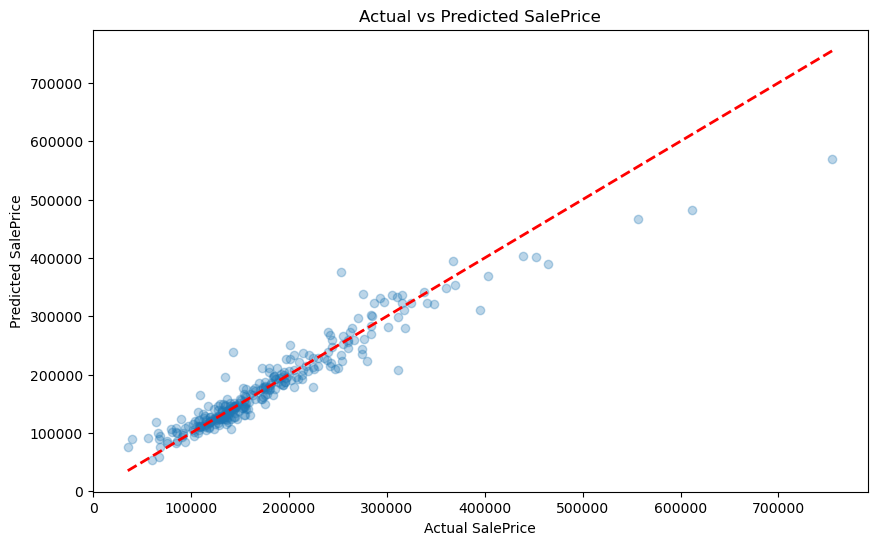

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data Preprocessing
def preprocess_data(df):
    # Handle missing values
    df = df.fillna(df.median(numeric_only=True))
    df = df.fillna(df.mode().iloc[0])

    # Encode categorical features
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    
    return df, label_encoders

train_df, train_encoders = preprocess_data(train_df)
test_df, test_encoders = preprocess_data(test_df)

# Split features and target variable
X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']
X_test = test_df

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred = xg_reg.predict(X_val)
y_test_pred = xg_reg.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

# Save the test set predictions to a CSV file
submission_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_test_pred})
submission_df.to_csv('result.csv', index=False)
